In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import matplotlib as mpl
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel('INFO')
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)
import urllib
from dataclasses import dataclass
# import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
import sys
np.random.seed(0)
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   
           })

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-ai/raw/master/scripts/active_learning_data/shp2-sequence-vectors.npy",
    "positive.npy",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-ai/raw/master/scripts/active_learning_data/shp2-fake-sequence-vectors.npy",
    "negative.npy",
)

pos_ohe_data = np.load("positive.npy",  allow_pickle=True)
neg_ohe_data = np.load("negative.npy",  allow_pickle=True)

def ohe_to_seq(ohe_pep):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    seq = ''
    # expect a 2D numpy array (pep_length x 20), give the string it represents
    for letter in ohe_pep[:int(np.sum(ohe_pep))]:
        idx = np.argmax(letter)
        if letter[idx] == 0:
            break
        seq += alphabet[idx]
    return(seq)

def encoder(seq, max_length=190):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    vec = np.zeros(max_length)
    for i,l in enumerate(seq):
        vec[i] = alphabet.index(l) + 1
    return vec
pos_seqs = [ohe_to_seq(d) for d in pos_ohe_data]
pos_data = np.array([encoder(s) for s in pos_seqs])
neg_seqs = [ohe_to_seq(d) for d in neg_ohe_data]
neg_data = np.array([encoder(s) for s in neg_seqs])

In [4]:
def split_train_test_data(pos, neg, test_size_pos=0.1, val_size=0.1, unlabeled_size=0.2, seed=None):
    np.random.seed(seed)
    np.random.shuffle(pos)
    np.random.shuffle(neg)
    from sklearn.model_selection import train_test_split
    pos, unlabeled_p, _, _ = train_test_split(pos, np.ones(pos.shape[0]),
                                                                        test_size=unlabeled_size, random_state=seed)
    X_test_negative, unlabeled_n, _, _ = train_test_split(neg, np.zeros(neg.shape[0]),
                                                                    test_size=unlabeled_size, random_state=seed)
    X_train_positive, X_test_positive, _, _ = train_test_split(pos, np.ones(pos.shape[0]),
                                                                                        test_size=test_size_pos, random_state=seed)
    X_train_positive, X_val_positive, _, _ = train_test_split(X_train_positive, np.ones(X_train_positive.shape[0]),
                                                                                    test_size=val_size, random_state=seed)
    X_unlabeled = np.concatenate([unlabeled_p, unlabeled_n])
    np.random.shuffle(X_unlabeled)
    
    print(X_train_positive.shape, X_val_positive.shape, X_test_positive.shape, X_test_negative.shape,  X_unlabeled.shape)
    return X_train_positive, X_val_positive, X_test_positive, X_test_negative, X_unlabeled

seed = 0
X_train_positive, X_val_positive, X_test_positive, X_test_negative, X_unlabeled = split_train_test_data(pos_data, neg_data, seed=seed)

print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Unlabeled data:', len(X_unlabeled))

(97, 190) (11, 190) (12, 190) (120, 190) (60, 190)
Positive data: 150
Negative data: 150
Unlabeled data: 60


In [5]:

# def build_fakes(n, data):
#     result = []
#     for _ in range(n):
#         # sample this many subsequences
#         k = np.clip(np.random.poisson(1), 0, len(data) - 2) + 2
#         idx = np.random.choice(range(len(data)), replace=False, size=k)                        
#         seq = []
#         lengths = []
#         # cut-up k into one new sequence
#         for i in range(k):
#             if np.argmin(data[idx[i]]) > 1:
#                 lengths.append(np.ceil(2 * np.random.randint(1, np.argmin(data[idx[i]])) / k).astype(int))
#                 j = np.random.randint(0, np.argmin(data[idx[i]]) - lengths[i])
#             else:
#                 lengths.append(1)
#                 j = 0
#             seq.append(data[idx[i]][j:j+lengths[i]])
#         # pad out    
#         seq.append([0] * (len(data[0]) - sum(lengths)))
#         # print(seq)
#         result.append(np.concatenate(seq))
#         # print(result)
#         # break
#     return np.array(result)
# sampled_vecs = build_fakes(pos_data.shape[0]*20, pos_data)


def spy(X_p, X_u, spied_rate=0.2, seed=None):
    np.random.seed(seed)
    X = np.vstack([X_p, X_u])
    y = np.concatenate([np.ones(X_p.shape[0]), np.zeros(X_u.shape[0])])
    # Step 1. Infuse spies
    spie_mask = np.random.random(X_p.shape[0]) < spied_rate
    # Unknown mix + spies
    MS = np.vstack([X[y == 0], X[y == 1][spie_mask]]) # this is actual features for mix+spies
    MS_spies = np.hstack([np.zeros((y == 0).sum()), np.ones(spie_mask.sum())]) # this is actual labels for mix+spies
    # Positive with spies removed
    P = X[y == 1][~spie_mask]
    # Combo
    MSP = np.vstack([MS, P]) # this is mix+spies added to positives
    # Labels
    MSP_y = np.hstack([np.zeros(MS.shape[0]), np.ones(P.shape[0])]) # this label for is mix+spies added to positives
    shuffler = np.random.permutation(len(MSP))
    MSP = MSP[shuffler]
    MSP_y = MSP_y[shuffler]
    return MSP, MSP_y, MS, MS_spies

def find_RN_threshold(y_hat, y, initial_t=0.00001, spied_tolerance= 0.025):
    # Find optimal t
    t = initial_t
    while  y[np.squeeze(y_hat <= t)].sum()/y.sum()  <= spied_tolerance:
        t += 0.0001
    print('Optimal t is {0:.06}'.format(t))
    print('Positive group size {1}, captured spies {0:.02%}'.format(
        y[np.squeeze(y_hat > t)].sum()/y.sum(), (y_hat > t).sum()))
    print('Likely negative group size {1}, captured spies {0:.02%}'.format(
        y[np.squeeze(y_hat <= t)].sum()/y.sum(), (y_hat <= t).sum()))
    return t

In [6]:

@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(pos_data), 
                batch_size=256, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model

class F1Score(tf.keras.metrics.Metric):
  def __init__(self, name='F1Score', **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)
    self.f1score = self.add_weight(name='F1Score', initializer='zeros')
    self.count = self.add_weight(name='F1ScoreCount', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    import keras.backend as K
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    true_positives = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    true_positives = tf.cast(true_positives, self.dtype)
    count_true_positives = tf.reduce_sum(true_positives)

    possible_positives = tf.cast(y_true, self.dtype)
    count_possible_positives = tf.reduce_sum(possible_positives)

    predicted_positives = tf.cast(y_pred, self.dtype)
    count_predicted_positives = tf.reduce_sum(predicted_positives)

    precision = count_true_positives / (count_predicted_positives + K.epsilon())
    recall = count_true_positives / (count_possible_positives + K.epsilon())
    f1_cal = 2*(precision*recall)/(precision + recall + K.epsilon())

    self.count.assign_add(1)
    a = 1.0 / self.count
    b = 1.0 - a
    self.f1score.assign(a*f1_cal+b*self.f1score)

  def result(self):
    return self.f1score

In [7]:
# from sklearn.model_selection import train_test_split
# X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(X_positive, np.ones(X_positive.shape[0]),
#                                                                                         test_size=0.1, random_state=42)
# X_train_unlabeled, X_test_unlabeled, y_train_unlabeled, y_test_unlabeled = train_test_split(X_unlabeled, np.zeros(X_unlabeled.shape[0]),
#                                                                                         test_size=0.5, random_state=42)
# X_test_L = np.concatenate([X_test_positive, X_test_unlabeled])
# y_test_L = np.concatenate([np.ones(y_test_positive.shape[0]), np.zeros(X_test_unlabeled.shape[0])])


In [8]:
# X_test = np.concatenate([X_test_positive, X_negative])
# y_test = np.concatenate([np.ones(y_test_positive.shape[0]), np.zeros(X_negative.shape[0])])

(array([60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 97.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

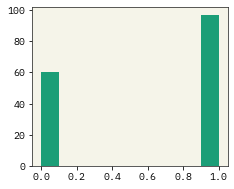

In [11]:
# np.random.seed(seed)
X = np.vstack([X_train_positive, X_unlabeled])
y = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(X_unlabeled.shape[0])])
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]
model = build_model(None)
plt.hist(y)

In [12]:
train_model = True
decay_epochs = 50
decay_steps = len(X)  // 16 * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(lr_decayed_fn)

if train_model:
    model = build_model(None)
    tf.keras.backend.clear_session()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=10, min_delta=1e-2, restore_best_weights=True)
    focal_loss  = tf.keras.losses.BinaryFocalCrossentropy(
                gamma=5, from_logits=False,  apply_class_balancing=True
                )
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    #     loss = focal_loss,
        metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5), F1Score()],
        )
    history = model.fit(
        [X, np.array([counts_aa(xi) for xi in X])] , y,
    #         validation_data=([X_test_L, np.array([counts_aa(xi) for xi in X_test_L])] , y_test_L),
        epochs=200,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1,
    )
#     # serialize model to JSON
#     inference_model_json = model.to_json()
#     with open("../saved_models/hemo-rnn/elkan_noto_model.json", "w") as json_file:
#         json_file.write(inference_model_json)
#     # serialize weights to HDF5
#     model.save_weights("../saved_models/hemo-rnn/elkan_noto_model_weights.h5")
    
else:
    # Inference model
    import keras
    # load json and create model
    json_file = open('../saved_models/shp2-rnn/elkan_noto_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    best_accuracy_threshold = 0.73
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    #     loss = focal_loss,
        metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=best_accuracy_threshold), F1Score()],
        )

    # load weights into new model
    model.load_weights("../saved_models/shp2-rnn/elkan_noto_model_weights.h5")

Epoch 1/200
3/3 [==============================] - 13s 23ms/step - loss: 0.8508 - auc: 0.5302 - binary_accuracy: 0.5414 - F1Score: 0.7632
Epoch 2/200
3/3 [==============================] - 0s 15ms/step - loss: 0.7583 - auc: 0.5775 - binary_accuracy: 0.5924 - F1Score: 0.7344
Epoch 3/200
3/3 [==============================] - 0s 13ms/step - loss: 0.7240 - auc: 0.6382 - binary_accuracy: 0.5987 - F1Score: 0.7760
Epoch 4/200
3/3 [==============================] - 0s 14ms/step - loss: 0.6348 - auc: 0.6884 - binary_accuracy: 0.6943 - F1Score: 0.7675
Epoch 5/200
3/3 [==============================] - 0s 14ms/step - loss: 0.5862 - auc: 0.7358 - binary_accuracy: 0.7134 - F1Score: 0.7802
Epoch 6/200
3/3 [==============================] - 0s 12ms/step - loss: 0.5959 - auc: 0.7227 - binary_accuracy: 0.6943 - F1Score: 0.7478
Epoch 7/200
3/3 [==============================] - 0s 13ms/step - loss: 0.5305 - auc: 0.7771 - binary_accuracy: 0.7707 - F1Score: 0.7767
Epoch 8/200
3/3 [=======================

In [13]:
# 0.9572 
c = np.mean(model.predict([X_val_positive, np.array([counts_aa(xi) for xi in X_val_positive])]))
print(c)

1/1 [==============================] - 4s 4s/step
0.7741427


In [14]:
R_indice = np.random.randint(0, X_val_positive.shape[0], X_val_positive.shape[0]//2)
y_hat_val =  model.predict([X_val_positive, np.array([counts_aa(xi) for xi in X_val_positive])])
c = np.sum(y_hat_val[R_indice]) / np.sum(y_hat_val)
c

1/1 [==============================] - 0s 24ms/step


0.45479146

In [15]:
X_test = np.concatenate([X_test_positive, X_test_negative])
y_test = np.concatenate([np.ones(X_test_positive.shape[0]), np.zeros(X_test_negative.shape[0])])
yhat_test =  model.predict([X_test, np.array([counts_aa(xi) for xi in X_test])])/c
# yhat_test = [0 if y < 0.5 else 1 for y in yhat_test ]

5/5 [==============================] - 0s 4ms/step


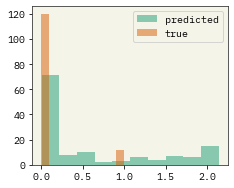

In [16]:
plt.hist(yhat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()

Best Threshold=1.119203, G-Mean=0.843
Accuracy: 0.780
F1 Score: 0.637
AUC: 0.870


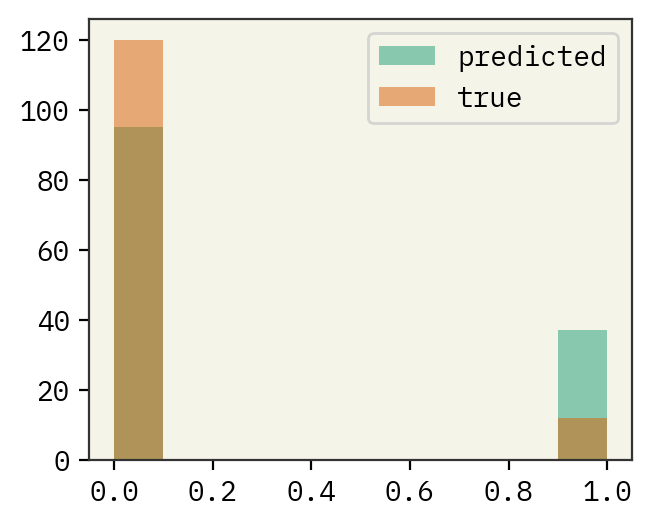

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_test, yhat_test, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in yhat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Accuracy: {acc:.3f}')
f1 = f1_score(y_test, adjusted_y_hat_test, average='macro')
print(f'F1 Score: {f1:.3f}')
auc = roc_auc_score(y_test, yhat_test, average='macro')
print(f'AUC: {auc:.3f}')
plt.figure(dpi=200)
plt.hist(adjusted_y_hat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()


Best ghostml Threshold=%f, 1.61
Accuracy: 0.841
F1 Score: 0.670
AUC: 0.870


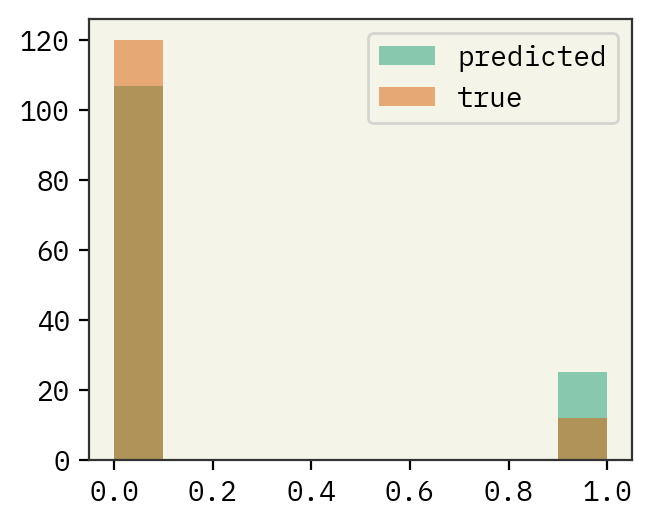

In [18]:
import warnings
warnings.filterwarnings('ignore')
import ghostml
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# train_probs = model_2.predict([NP, np.array([counts_aa(xi) for xi in NP])])
thresholds = np.round(np.arange(0.1,1/c-0.5,0.005),2)
threshold1 = ghostml.optimize_threshold_from_predictions(y_test, yhat_test[:,0], thresholds, ThOpt_metrics = 'Kappa')
print(f'\nBest ghostml Threshold=%f, {threshold1}')
best_accuracy_threshold = threshold1
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in yhat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Accuracy: {acc:.3f}')
f1 = f1_score(y_test, adjusted_y_hat_test, average='macro')
print(f'F1 Score: {f1:.3f}')
auc = roc_auc_score(y_test, yhat_test, average='macro')
print(f'AUC: {auc:.3f}')

plt.figure(dpi=200)
plt.hist(adjusted_y_hat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()

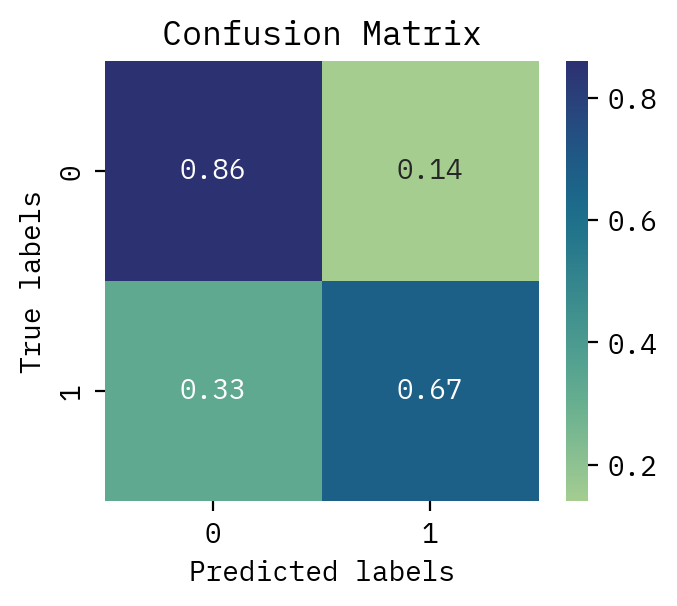

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, adjusted_y_hat_test, normalize='true')
# fig = plt.figure(dpi= 200)
plt.figure(dpi=200)
sns.heatmap(np.round(cm, 2), annot=True, fmt='g', ax=plt.gca(), cmap="crest");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax=plt.gca()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
